In [8]:
text_input = 'kar f\u0131rt\u0131nas\u0131ndaki \xE7am a\u011Fac\u0131' #@param {type: "string"}

num_images_to_generate = 3 #@param {type: "number"}

In [9]:
#!pip install torch==1.9.1 torchtext==0.10.1 torchvision==0.10.1 torchaudio==0.10.1
#%cd /content
#!git clone https://github.com/drboog/Lafite
#%cd /content/Lafite
#!pip install git+https://github.com/openai/CLIP.git
#!pip install googletrans==4.0.0-rc1
#!pip install ninja


  Using cached torch-1.9.1-cp37-cp37m-manylinux1_x86_64.whl (831.4 MB)
  Using cached torchtext-0.10.1-cp37-cp37m-manylinux1_x86_64.whl (7.6 MB)
  Using cached torchvision-0.10.1-cp37-cp37m-manylinux1_x86_64.whl (22.1 MB)
  Using cached torchaudio-0.10.1-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torchtext to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of <Python from Requires-Python> to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install torch==1.9.1, torchaudio==0.10.1, torchtext==0.10.1 and torchvision==0.10.1 bec

In [10]:
#Pre trained file was too big for github to upload so you can download it here
!wget -N https://public-ipfs-gateway.pollinations.ai/ipfs/Qmdt4erch9AHveSh9JohEHqUGFMdfThsXJknwHjtQUQJQhe/pre-trained-google-cc-best-fid.pkl

--2022-04-12 12:41:03--  https://public-ipfs-gateway.pollinations.ai/ipfs/Qmdt4rch9AHveSh9JohEHqUGFMdfThsXJknwHjtQUQJQhe/pre-trained-google-cc-best-fid.pkl
Resolving public-ipfs-gateway.pollinations.ai (public-ipfs-gateway.pollinations.ai)... 65.108.44.19
Connecting to public-ipfs-gateway.pollinations.ai (public-ipfs-gateway.pollinations.ai)|65.108.44.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 478149328 (456M) [application/octet-stream]
Saving to: ‘pre-trained-google-cc-best-fid.pkl’

  pre-trained-googl   5%[>                   ]  23.56M  11.7MB/s               ^C


# Yeni Bölüm

In [11]:
import torch
import numpy as np
import pickle
import os
import clip
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import dnnlib, legacy
import clip
import torch.nn.functional as F
import torchvision.transforms as T
from tqdm import tqdm
import scipy
from googletrans import Translator

In [12]:
class Generator:
    def __init__(self, device, path):
        self.name = 'generator'
        self.model = self.load_model(device, path)
        self.device = device
        self.force_32 = False
        
    def load_model(self, device, path):
        with dnnlib.util.open_url(path) as f:
            network= legacy.load_network_pkl(f)
            self.G_ema = network['G_ema'].to(device)
            self.D = network['D'].to(device)
#                 self.G = network['G'].to(device)
            return self.G_ema
        
    def generate(self, z, c, fts, noise_mode='const', return_styles=True):
        return self.model(z, c, fts=fts, noise_mode=noise_mode, return_styles=return_styles, force_fp32=self.force_32)
    
    def generate_from_style(self, style, noise_mode='const'):
        ws = torch.randn(1, self.model.num_ws, 512)
        return self.model.synthesis(ws, fts=None, styles=style, noise_mode=noise_mode, force_fp32=self.force_32)
    
    def tensor_to_img(self, tensor):
        img = torch.clamp((tensor + 1.) * 127.5, 0., 255.)
        img_list = img.permute(0, 2, 3, 1)
        img_list = [img for img in img_list]
        return Image.fromarray(torch.cat(img_list, dim=-2).detach().cpu().numpy().astype(np.uint8))

In [16]:
with torch.no_grad():

    device = 'cuda:0' # please use GPU, do not use CPU
    path = '/content//Lafite/model.pkl'  # pre-trained model
    generator = Generator(device=device, path=path)
    clip_model, _ = clip.load("ViT-B/32", device=device)
    clip_model = clip_model.eval()
    
    ###insert any language converter here for quick solution i use google translate
    translator = Translator()
    print(text_input)
    text_model_input = translator.translate(text_input,src='tr',dest="en").text
    ################################################################################

    tokenized_text = clip.tokenize([text_model_input]*num_images_to_generate).to(device)
    txt_fts = clip_model.encode_text(tokenized_text)
    txt_fts = txt_fts/txt_fts.norm(dim=-1, keepdim=True)
    
    z = torch.randn((num_images_to_generate, 512)).to(device)
    c = torch.randn((num_images_to_generate, 1)).to(device) # label is actually not used
    img, _ = generator.generate(z=z, c=c, fts=txt_fts)
    to_show_img = generator.tensor_to_img(img)
    to_show_img.save('./generated.jpg')
    to_show_img


100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 64.6MiB/s]


kar fırtınasındaki çam ağacı
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


pine tree in the snowstorm


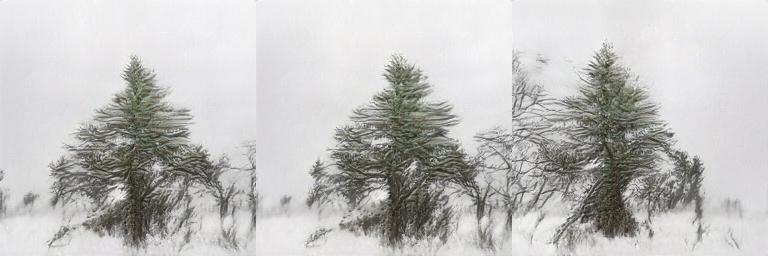

In [17]:
    from IPython.display import Image
    print(text_model_input)
    Image(filename='./generated.jpg') 
  